<a href="https://colab.research.google.com/github/Location-Artistry/GEO-DEV-NOTEBOOKS/blob/main/waterDataExport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Working Water Data Pandas AWQMS Export**
Updated August 12th - Working with pandas dataframe exporting to excel   
Working function to run download and CSV formatting in pandas   
**8-14 Completed: Download & Export Functions, QuickMap Display**
**8-25 delMultiple, updated Kzoo Dashboard Status**   
**8-25 This Notebook has most current Python Functions!!!**

# Install and Import Libraries
**RUN FIRST**

In [ ]:
!pip install xlsxwriter
!pip install xlrd
!pip install openpyxl
!pip install arcgis
#!pip install pdfkit
#import pdfkit
import pandas as pd
from pathlib import Path
import sys
import os
import datetime as dt
import time as tm
import math
from arcgis.gis import GIS, Item
from arcgis.env import active_gis
from arcgis.features import FeatureLayerCollection
from arcgis.mapping import WebMap
from IPython.display import display
import getpass
from pathlib import Path
from zipfile import ZipFile
from openpyxl import load_workbook

     |████████████████████████████████| 153kB 8.2MB/s 
     |████████████████████████████████| 2.0MB 7.2MB/s 
  Using cached https://files.pythonhosted.org/packages/e4/ed/7be20815f248b0d6aae406783c2bee392640924623c4e17b50ca90c7f74d/keyring-21.4.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f2/20/73c8fa29a4ba8f8cbdb037369e6b61ac9253664a8aa0912b52169192447f/lerc-0.1.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/82/bc/8ca618d6a18d49675ad39f544bcd6ad8a9f31a5784d059d7053c8ec3197b/jupyterlab-2.2.7-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ca/1f/e9cc2c3fce32e2926581f8b6905831165235464c858ba550b6e9b8ef78c3/pyshp-2.1.2.tar.gz
  Using cached https://files.pythonhosted.org/packages/60/ef/7681134338fc097acef8d9b2f8abe0458e4d87559c689a8c306d0957ece5/requests_toolbelt-0.9.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/03/4b/8b9a1afde8072c4d5710d9fa91433d504325821b038e00237dc8d6d833dc/requests_n

# Python Functions from my ArcGIS Python Colab Notebook  
**MUST RUN THIS CELL AFTER INSTALL AND IMPORT THEN - userLogin() -**


In [ ]:
# Collection of all ArcGIS Python API Helper Functions
# user login functions, ask if user would like additional logins
def userLogin():
    userID = input(f'ArcGIS Online USER ID: ')
    passWord = getpass.getpass('PASSWORD: ')
    try:
        global gis
        gis = GIS("https://www.arcgis.com", userID, passWord)
        print(f'SUCCESS - CONNECTED TO: {gis.users.me.username} ACCOUNT as <gis>')
        print(gis)
        addUsers = input(f'Additional User Login(YES/NO)? ')
        if addUsers.upper() == 'YES':
            additionalUserLogin()
        else:
            print(f'YOU MAY NOW PROCEED...')
    except:
        print(f'ERROR DID NOT CONNECT TO: {userID}')

def additionalUserLogin():
    userID = input(f'ArcGIS Online USER ID: ')
    passWord = getpass.getpass('PASSWORD: ')
    try:
        global gis2
        gis2 = GIS("https://www.arcgis.com", userID, passWord)
        print(f'SUCCESS - CONNECTED TO: {gis2.users.me.username} ACCOUNT as <gis2>')
        print(gis2)
    except:
        print(f'ERROR DID NOT CONNECT TO: {userID}')

# get list of all owner AGOL items, print list with title, id, type, and categories
def getUserContent(gisInfo):
    try:
        my_content = gisInfo.content.search(query="owner:" + gisInfo.users.me.username, item_type="", max_items=200)
        for x in my_content:
            strMod = str(x.modified)
            stampInt = int(strMod[0:10])
            print(f'{x.title} - {x.id} - {x.type} - {x.categories} - {dt.datetime.fromtimestamp(stampInt)}')
    except:
        print('ERROR could not get user content')

# Clone item using id of item passed to function
def cloneItem(gisInfo, gisInfo2, cloneID):    
    try:
        itemToClone = gisInfo.content.get(cloneID)
        print('Cloning:' + itemToClone.title + ' - ' + itemToClone.id + ' -',itemToClone.type)
        clonedItem = gisInfo2.content.clone_items(items=[itemToClone])
        print(f'Cloned Item: {clonedItem[0]}')
        #return clonedItem
    except:
        print('ERROR Could Not Clone')

# updated searchByKeywords, returns LIST of items 8-14-2020
def searchByKeywords(gisInfo, searchKeywords):
    try:
        searchContent = gisInfo.content.search(query=f'{searchKeywords}', item_type='', max_items=50)
        x = 0
        for z in searchContent:
          strMod = str(z.modified)
          stampInt = int(strMod[0:10])
          print(f'{x} - {z.title} - {z.id} - {z.type} - {z.categories} - {dt.datetime.fromtimestamp(stampInt)}')
          x += 1
        return searchContent
    except:
        print('ERROR Search not Successful')

# find item by keywords and display visual card
def searchByKeyViz(gisInfo, searchKeywords):
    try:
        searchContent = gisInfo.content.search(query=f'{searchKeywords}', item_type='', max_items=50)
        for z in searchContent:
            print(f'title: {z.title} - itemID: {z.id} - type: {z.type}')
            display(z)
    except:
        print('ERROR Search not Successful')
        
# return all keys and values for item when passed itemID string
def getItemKeysValues(gisInfo, idString):
    try:
        getFeature = gisInfo.content.get(idString)
        for key, value in getFeature.items():
            print(key,': ', value)
    except:
        print('ERROR GET Keys/Values not Successful')
        
# takes itemID and gets and returns layerObject if exist, otherwise 'no layers found'
def getLayers(gisInfo, idString):
    getFeature = gisInfo.content.get(idString)
    try:
        featureLayers = getFeature.layers
        z = 0 
        for x in featureLayers:
            print(f'Layer {z}: {x}')
            z += 1
    except:
        print('no layers found')
    return featureLayers

# supply feature layer itemID, and the layer number to display table head 
def getLayerTable(gisInfo, idString, layerNum):
    try:
        layerOutput = getLayers(gisInfo, idString)
        queryLayer = layerOutput[layerNum].query()
        display(queryLayer.sdf.head())
    except:
        print('ERROR no Layers Found')
        
# delete item by itemID
def deleteItem(gisInfo, idString):
    itemToDelete = gisInfo.content.get(idString)
    display(itemToDelete)
    delQuest = input(f'Are you sure you want to delete: {itemToDelete.title}')
    try:
        if delQuest.upper() == 'YES':
            print(f'DELETING: {itemToDelete.title}')
            itemToDelete.delete()
        else:
            print(f'NOT DELETING: {itemToDelete.title}')
    except:
        print(f'ERROR failed to DELETE: {itemToDelete.title}')

# delete multiple items by searchByKeywords() returned LIST 8-14-2020
def delMultiple(gisInfo, itemList):
  try:
    print('List of Items to be Deleted: ')
    for z in itemList:
          strMod = str(z.modified)
          stampInt = int(strMod[0:10])
          print(f'{z.title} - {z.id} - {z.type} - {z.categories} - {dt.datetime.fromtimestamp(stampInt)}')
    delQuest = input(f'SURE YOU WANT TO DELETE THESE?!?!?')
    if delQuest.upper() == 'YES':
      for z in itemList:
          print(f'DELETING {z.title}')
          itemToDelete = gisInfo.content.get(z.id)
          itemToDelete.delete()
      print('<FINISHED DELETION PROCESS>')
    else:
      print(f'NOT DELETING!')
  except:
      print(f'ERROR failed to DELETE: {itemToDelete.title}')

# List all user Dashboards and Dashboard Webmmaps
def ListAllDashWebmaps(gisInfo):
  source_admin_inventory = get_user_items(gisInfo, gisInfo.users.me)
  x = 0
  try:
    for dashboard in source_admin_inventory['Dashboard']:
        print(x, dashboard)
        dashWebmap = get_dash_wm(gisInfo, dashboard)
        print(dashWebmap)
        x += 1
  except:
    print("ERROR COULD NOT LIST DASHBOARDS") 

# generic function update targetLayer Features based on Table Records
def updateLayFeatFromTable(gisInfo, targetLayerID, matchAttrib, targetAttrib, sourceAttrib):
  try:
    getLayers = gisInfo.content.get(targetLayerID)
    targetLayer = getLayers.layers
    layerFeatures = targetLayer[0].query()
    sourceTable = getLayers.tables
    tableFeatures = sourceTable[0].query()
    for tableFeature in tableFeatures:
      tableFeatureID = tableFeature.attributes[matchAttrib]
      for layerFeature in layerFeatures:
        layerFeatureID = layerFeature.attributes[matchAttrib]
        if tableFeatureID == layerFeatureID:
          targetValue = tableFeature.attributes[sourceAttrib]
          layerFeature.set_value(targetAttrib, targetValue)
          print(f'feature: {layerFeatureID} from tableFeature: {tableFeatureID} set {targetAttrib} as: {targetValue}')
    layerEdits = targetLayer[0].edit_features(updates=layerFeatures)
    editCounter = 0
    for edits in layerEdits['updateResults']:
      editCounter+=1
    print(f'updated {getLayers.title} with {editCounter} edits from {getLayers.tables[0]}')
  except:
    print(f'update features failed for {getLayers.title}')
  
# generic function update targetLayer Features based on Table Record, adds break list for parameter categories mapping/analysis
# 8-14 Updated to screen for sampling records with blank values: 'None'
def updateLayFeatFromTableBreaks(gisInfo, targetLayerID, matchAttrib, targetAttrib, sourceAttrib, breaksList):
  try:
    getLayers = gisInfo.content.get(targetLayerID)
    targetLayer = getLayers.layers
    layerFeatures = targetLayer[0].query()
    sourceTable = getLayers.tables
    tableFeatures = sourceTable[0].query()
    for tableFeature in tableFeatures:
      #tableFeatureID = tableFeature.attributes[matchAttrib]
      print(tableFeature.attributes['WATER_TEMP'] is None)
      if (tableFeature.attributes['WATER_TEMP'] is None) != True:
        tableFeatureID = tableFeature.attributes[matchAttrib]
        for layerFeature in layerFeatures:
          layerFeatureID = layerFeature.attributes[matchAttrib]
          if tableFeatureID == layerFeatureID:
            targetValue = tableFeature.attributes[sourceAttrib]
            x = 1
            for breakVal in breaksList:
              if targetValue > breakVal:
                print('none')
              else:
                layerFeature.set_value(targetAttrib, x)
                print(f'feature: {layerFeatureID} from tableFeature: {tableFeatureID} set {targetAttrib}: {targetValue} as: {x}')
                break
              x+=1
    layerEdits = targetLayer[0].edit_features(updates=layerFeatures)
    editCounter = 0
    for edits in layerEdits['updateResults']:
      editCounter+=1
    # hide REST infor for updated layers and tables
    # print(f'updated {getLayers.title} with {editCounter} edits from {getLayers.tables[0]}')
    print(f'updated {getLayers.title} with {editCounter} edits')
  except:
    print(f'update features failed for {getLayers.title}')

# download Feature Layer data from AGOL, unzip contents to folder with item.title name
# Export Formats: Shapefile | CSV | File Geodatabase | Feature Collection | GeoJson | Scene Package | KML | Excel
def downloadItem(gisInfo, idString):
    try:
        downloadData = gisInfo.content.get(idString)
        dataPath = Path('/data')
        print(f'Downloading: {downloadData.title} to {dataPath} directory')
        if not dataPath.exists():
          dataPath.mkdir()
        # this portion for feature service
        downloadExport = downloadData.export(title=downloadData.title, export_format="CSV")
        zipPath = downloadExport.download(save_path=dataPath)
        # preparing to extract files to directory with item.title name
        #zipPath = downloadData.download(save_path=dataPath)
        extractPath = dataPath.joinpath(downloadData.title)
        # extract files to /data directory
        zipFiles = ZipFile(zipPath)
        zipFiles.extractall(path=extractPath)
        print(f'list of Files extracted to: {extractPath}')
        print(list(file.name for file in extractPath.glob('*')))
    except:
        print('ERROR DOWNLOAD did not workings!')

def searchItem(gisInfo, searchKeywords, itemType):
    try:
        searchContent = gisInfo.content.search(query=f'{searchKeywords}', item_type=itemType, max_items=25)
        if itemType == 'Feature Service':
            x = 0
            print(f'<Search Query for {searchKeywords}>')
            for z in searchContent:
                strMod = str(z.modified)
                stampInt = int(strMod[0:10])
                print(f'{x} - {z.title} - {z.id} - {z.type} - {z.categories} - {dt.datetime.fromtimestamp(stampInt)}')
                x += 1
            layInd = int(input(f'Index of selected Feature Layer: '))
            addLayer = gisInfo.content.get(searchContent[layInd].id)
            return addLayer
        elif itemType == 'Web Map':
            x = 0
            print(f'<Search Query for {searchKeywords}>')
            for z in searchContent:
                strMod = str(z.modified)
                stampInt = int(strMod[0:10])
                print(f'{x} - {z.title} - {z.id} - {z.type} - {z.categories} - {dt.datetime.fromtimestamp(stampInt)}')
                x += 1
            layInd = int(input(f'Index of selected Feature Layer: ')) or 'NONE'
            #print(searchContent[layInd])
            mapReturn = searchContent[layInd]
            return mapReturn
    except:
        print('ERROR Search not Successful')
        
def quickMap():
  mapType = input(f'(YES) for QuickMap (NO) for Existing: ')
  if mapType.upper() == 'NO':
    mapSize = ['480px','720px','960px']
    print(f'<You entered {mapType} please login below>')
    userLogin() 
    mapKeywords = input(f'Name of WebMap to Search for: ') or ''
    mapObj = searchItem(gis,mapKeywords,'Web Map')
    map = gis.map(mapObj)
    sizeIn = int(input(f'MAP SIZE (0)SMALL (1)MEDIUM (2)HUGE: '))
    map.layout.height = mapSize[sizeIn]
    display(map)
  else:
    print(f'<You entered {mapType} Opening QuickMap>')
    mapList = ['topo','hybrid','streets','dark-gray','terrain']
    mapDimen = ['2D','3D']
    mapSize = ['480px','720px','960px']
    mapLoc = input(f'Location (default=Michigan): ') or 'Michigan'
    mapBaseNum = input(f'Basemap (default=topo (1=hybrid,2=streets,3=dark-gray,4=terrain): ') or 0
    mapDimIn = input(f'ENTER (1) for 3D Map: ') or 0
    atlasLayers = input(f'Layers from Living Atlas(Enter for None): ') or 'NONE'
    gisNone = GIS()
    map = gisNone.map(mapLoc)
    map.basemap = mapList[int(mapBaseNum)]
    if atlasLayers != 'NONE':
        layerDisplay = searchItem(gisNone, atlasLayers,'Feature Service')
        for layrs in layerDisplay.layers:
            map.add_layer(layrs)
    map.mode = mapDimen[int(mapDimIn)]
    sizeIn = int(input(f'MAP SIZE (0)SMALL (1)MEDIUM (2)HUGE: '))
    map.layout.height = mapSize[sizeIn]
    display(map)

# Delete all features from selected Feature Service, may need more debugging
def delAllFeatures(gisInfo, idString):
    delFeatures = gisInfo.content.get(idString)
    display(delFeatures)
    delQuest = input(f'Are you sure you want to delete all the feature in? {delFeatures.title}')
    try:
        if delQuest.upper() == 'YES':
            print('in loop')
            print(f'DELETING ALL FEATURES IN: {delFeatures.title}')
            featDelRes = []
            targetLayer = delFeatures.layers
            layerFeatures = targetLayer[0].query()
            for feature in layerFeatures:
              #print(f'features: {feature.attributes}')
              featDelRes.append(targetLayer[0].edit_features(deletes=str(feature.attributes['objectid'])))
            return featDelRes
        else:
            print(f'NOT DELETING: {delFeatures.title}')
    except:
        print(f'ERROR failed to DELETE: {delFeatures.title}')

# *******ESRI pre-made helper functions********
def is_hosted(gisInfo, item):
    return [keyword for keyword in item.typeKeywords if "Hosted" in keyword] 

# Prints all layers in a webmap, very handy
def print_webmap_inventory(gisInfo, wm):
    wm_obj = WebMap(wm)
    print(f"{wm_obj.item.title}\n{'-'*100}")
    for wm_layer in wm_obj.layers:
        try:
            if is_hosted(Item(gisInfo, wm_layer['itemId'])):
                print(f"{' '*2}{wm_layer['title']:40}HOSTED{' ':5}"
                      f"{wm_layer['layerType']:20}{dict(wm_layer)['itemId']}")
            else:
                print(f"{' '*2}{wm_layer['title']:40}other{' ':6}"
                      f"{wm_layer['layerType']:20}{wm_layer.id}") 
        except:
            print(f"{' '*2}{wm_layer['title']:40}other{' ':6}"
                  f"{wm_layer['layerType']:20}{wm_layer.id}")
    print("\n")

def get_webmap_list(wm):
    wm_obj = WebMap(wm)
    wmList = []
    print(f"{wm_obj.item.title}\n{'-'*100}")
    for wm_layer in wm_obj.layers:
        # print(wm_layer.itemId)
        wmList.append(wm_layer.itemId)
    return(wmList)
    
def displayWebmapLayers(gisInfo, idList):
    for id in idList:
        displayLayer = gisInfo.content.get(id)
        display(displayLayer)

def get_user_items(gisInfo, user):
    user_inventory = {}
    user_items = gisInfo.content.search(query=f"* AND owner:{user.username}", 
                                           max_items=500)
    for item in user_items:
        if item.type not in user_inventory:
            user_inventory[item.type] = [i 
                                         for i in user_items 
                                         if i.type == item.type]
    return user_inventory

def print_user_inventory(inventory):
    for itype, ilist in inventory.items():
        try:
            print(f"{itype}\n{'-'*50}")
            for i in ilist:
                print(f"{' ':3}{i.title:50}")
            print("\n")
        except Exception as e:
            print(f"\t\tOperation failed on: {i.title}")
            print(f"\t\tException: {sys.exc_info()[1]}")
            continue
            
def get_dash_wm(gisInfo, dash):
    return [gisInfo.content.get(widget['itemId']) 
            for widget in dash.get_data()['widgets'] 
            if widget['type'] == "mapWidget"]

# Python API Function List  
**userLogin()** - **additionalUserLogin()** - **getUserContent** *(gisInfo)* - **cloneItem** *(gisInfo, gisInfo2, cloneID)*  
**searchByKeywords** *(gisInfo, searchKeywords)* - **searchByKeyViz** *(gisInfo, searchKeywords)*  
**getItemKeysValues** *(gisInfo, idString)* - **getLayers** *(gisInfo, idString)*
**getLayerTable** *(gisInfo, idString, layerNum)* - **deleteItem** *(gisInfo, idString)*  
**ListAllDashWebmaps** *(gisInfo)* - **updateLayFeatFromTable** *(gisInfo, targetLayerID, matchAttrib, targetAttrib, sourceAttrib)*  
**updateLayFeatFromTableBreaks** *(gisInfo, targetLayerID, matchAttrib, targetAttrib, sourceAttrib, breaksList)*  
**downloadItem** *(gisInfo, idString)* - **searchItem** *(gisInfo, searchKeywords, itemType)* - **quickMap()**   
**delAllFeatures** *(gisInfo, itemID)* - **delMultiple** *(gisInfo, itemList)*


---


# ESRI pre-made helper functions  
**is_hosted** *(gisInfo, item)* - **print_webmap_inventory** *(gisInfo, wm)* - **get_webmap_list** *(wm)*  
**displayWebmapLayers** *(gisInfo, idList)* - **get_user_items** *(gisInfo, user)*  
**print_user_inventory** *(inventory)* - **get_dash_wm** *(gisInfo, dash)*


# Work in Progress Cell(s)

# Water Quality Dashboard Display Update Functions
Updated KZOO Turb Status 7-23-2020 3:05 pm   
Updated NHBP DO Status 7-23-2020 3:08 pm
Upated NHBP DO Status 8-12-2020    
Updated KZOO Turb Status 8-15-2020 - Refactored Update Layer function, check for 'None'

In [ ]:
# generic function update targetLayer Features based on Table Record, adds break list for parameter categories mapping/analysis
# 8-14 Updated to screen for sampling records with blank values: 'None'
def updateLayFeatFromTableBreaks(gisInfo, targetLayerID, matchAttrib, targetAttrib, sourceAttrib, breaksList):
  try:
    getLayers = gisInfo.content.get(targetLayerID)
    targetLayer = getLayers.layers
    layerFeatures = targetLayer[0].query()
    sourceTable = getLayers.tables
    tableFeatures = sourceTable[0].query()
    for tableFeature in tableFeatures:
      #tableFeatureID = tableFeature.attributes[matchAttrib]
      print(tableFeature.attributes['WATER_TEMP'] is None)
      if (tableFeature.attributes['WATER_TEMP'] is None) != True:
        tableFeatureID = tableFeature.attributes[matchAttrib]
        for layerFeature in layerFeatures:
          layerFeatureID = layerFeature.attributes[matchAttrib]
          if tableFeatureID == layerFeatureID:
            targetValue = tableFeature.attributes[sourceAttrib]
            x = 1
            for breakVal in breaksList:
              if targetValue > breakVal:
                print('none')
              else:
                layerFeature.set_value(targetAttrib, x)
                print(f'feature: {layerFeatureID} from tableFeature: {tableFeatureID} set {targetAttrib}: {targetValue} as: {x}')
                break
              x+=1
    layerEdits = targetLayer[0].edit_features(updates=layerFeatures)
    editCounter = 0
    for edits in layerEdits['updateResults']:
      editCounter+=1
    # hide REST infor for updated layers and tables
    # print(f'updated {getLayers.title} with {editCounter} edits from {getLayers.tables[0]}')
    print(f'updated {getLayers.title} with {editCounter} edits')
  except:
    print(f'update features failed for {getLayers.title}')

#userLogin()
kzooLayerNHBP = 'dff379381a6b4b73a1d80b9fd42784a8'
kzooLayerLA = '6b62d8b710e64b8abc79015fd7231b87'
waterSampNHBP = '680016d676e746f98743f51d28abac60'
match = 'SITE_ID'
turbTarget = 'TURB_STATUS_'
turbSource = 'TURB_NTU'
turbRefList = [3.93,10,40,1000]
DOtarget = 'DO_STATUS_'
DOsource = 'DO_mgl'
DOrefList = [5,6,7,100]
# calc Turbidity Status from most recent sample
#updateLayFeatFromTableBreaks(gis, kzooLayerNHBP, match, turbTarget, turbSource, turbRefList)
# calc DO Status from most recent sample
updateLayFeatFromTableBreaks(gis, waterSampNHBP, match, DOtarget, DOsource, DOrefList)

# **Working function to download and process WATER DATA**

1.   (COMP) Download and extract WATER_SAMPLING_2020 (itemID: '680016d676e746f98743f51d28abac60')  
2.   (COMP) Read Water Data Sample Table as Pandas Dataframe  
3. (COMP)Drop uneeded columns/attributes  
4. (NEXT STEP) Format correctly for AWQMS upload
5. Write as XLS for export to AWQMS


In [ ]:
# downloadReturn and exportAGOLdata work together with specified itemID to 
# package Export from AGOL into CSV, download and extract files, pass file
# path back to export func which creates pandas dataframe, 
# ALL WORKING 9-9 -> Finishing Refactoring...
# 9-10 -> AQWMS issues, fixed dates and times columns, more robust
def exportWaterData():
  
  def downloadReturn(gisInfo, idString):
    try:
        downloadData = gisInfo.content.get(idString)
        dataPath = Path('/data')
        print(f'Downloading: {downloadData.title} to {dataPath} directory')
        if not dataPath.exists():
          dataPath.mkdir()
        # this portion for feature service
        downloadExport = downloadData.export(title=downloadData.title, export_format="CSV")
        zipPath = downloadExport.download(save_path=dataPath)
        # preparing to extract files to directory with item.title name
        extractPath = dataPath.joinpath(downloadData.title)
        # extract files to /data directory
        zipFiles = ZipFile(zipPath)
        zipFiles.extractall(path=extractPath)
        # delete CSV created by export
        print(f'Deleting CSV export generated by Download: {downloadExport.title} ID: {downloadExport.id}')
        itemToDelete = gisInfo.content.get(downloadExport.id)
        itemToDelete.delete()
        print(f'list of Files extracted to: {extractPath}')
        print(list(file.name for file in extractPath.glob('*')))
        returnArray = []
        for x in extractPath.glob('*'):
          returnArray.append(x)
        return returnArray
    except:
        print('ERROR DOWNLOAD did not workings!')

  def exportDataFrame(df, exportName):
    try:
      writer = pd.ExcelWriter(exportName, engine='xlsxwriter')
      df.to_excel(writer, sheet_name='Sheet1', index=False)
      writer.save()
      print(f'dataframe successfully exported as: {exportName}')
      return df
    except:
      print('exportDataFrame function failed')

  # function to download and process data as specified above
  def exportAGOLdata(gis, itemID, exportName='exportXLS.xlsx'):
    try:
      DLdata = downloadReturn(gis, itemID)
      if str(DLdata[0])[-5] == '1':
        fullPath = DLdata[0]
      else: 
        fullPath = DLdata[1]
      print(fullPath)
      df = pd.read_csv(fullPath)
      display(df)
      dfED = exportDataFrame(df,exportName)
      print('<Dataframe Header created from AGOL item Export>')
      return dfED
    except:
      print(f'ERROR with {itemID} EXPORT')

  #Done 9-8-2020 - Just need to organize!
  # 9-9 -> Cleanup up and organized into functions, dfV2 local/global resolved
  def formatXLS(dfEX):
    # Lookup dict for site number linked to ID, define destination dataFrame
    siteList = {'DKC-ST-30':1,'DKC-ST-50':2,'FDP-SD-10':3,'ICD-ST-20':4,'ICD-ST-40':5,'ICD-ST-60':6,'KAR-ST-100':7,'KAR-ST-200':8,'NOT-ST-110':9,'NOT-ST-120':10,'NOT-ST-130':11,'NOT-ST-30':12,'NOT-ST-50':13,'NOT-ST-60':14,'NOT-ST-70':15,'NOT-ST-80':16,'NOT-ST-90':17,'PGC-ST-30':18,'PNC-ST-20':19,'PNC-ST-30':20,'PNC-ST-40':21,'PNC-ST-50':22,'PNC-ST-60':23,'PNC-ST-70':24,'QDP-LA-10':25,'RDP-SD-10':26,'SCD-ST-20':27,'SCD-ST-40':28,'SCD-ST-50':29,'SDP-LA-10':30,'UNT-ST-10':31,'UNT-ST-20':32,'ICD-ST-70':33,'HVC-ST-20':34,'NOT-ST-140':35,'NOT-ST-40':36,'DKC-ST-20':37,'DKC-ST-25':38,'NOT-ST-115':39,'PNC-ST-45':40,'ICD-ST-65':41,'SPC-ST-90':42,'SJR-ST-300':43}
    dfV2 = pd.DataFrame()
    # Define functions to transform/convert values for attributes
    def actType(QCval):
        if QCval == 'Field Measurement':
          return 'Field Msr/Obs'
        else:
          return 'Quality Control Field Replicate Msr/Obs'
    def FtoC(Ftemp):
      Ctemp = (int(Ftemp) - 32) * (5/9)
      return round(Ctemp, 2)
    def getDate(dateTime):
      splitDate = dateTime.split('/')
      if int(splitDate[0]) < 10:
        monthName = '0' + splitDate[0]
      else:
        monthName = splitDate[0]
      if int(splitDate[1]) < 10:
        dayName = '0' + splitDate[1]
      else:
        dayName = splitDate[1]
      splitDate = splitDate[2].split(' ')
      sampYear = splitDate[0]
      dateString = (f'{sampYear}{monthName}{dayName}')
      return dateString
    def isQC(qcInfo):
      returnVal = ''
      if qcInfo == 'Quality Control Sample Field Replicate':
        returnVal = ':QC'
      return returnVal
    def dateInfo(DATE_TIME):
      splitDate = DATE_TIME.split(' ')
      return splitDate
    def time24(DATE_TIME):
      splitTime = DATE_TIME.split(' ')
      dayTime = splitTime[1]
      dayTime = dayTime.split(':')
      hourTime = int(dayTime[0])
      minTime = int(dayTime[1])
      if minTime < 10:
        minTime = (f'0{str(minTime)}')
      if splitTime[2].upper() == 'PM':
        hourTime = int(dayTime[0]) + 12
      hourTime = hourTime - 5
      if hourTime < 10:
        hourTime = (f'0{str(hourTime)}')
      return hourTime,minTime
    def equipType(SAMP_EQUIP):
      if SAMP_EQUIP.upper() == 'YSI PRODSS':
        equipType = 'Probe/Sensor'
      else:
        equipType = 'Water Bottle'
      return equipType

    def convertValues():
      dfEX['SAMP_EQUIP'] = dfEX.apply(lambda row: equipType(row.SAMP_EQUIP), axis=1)
      dfEX['SITE #'] = dfEX.apply(lambda row: siteList[row.SITE_ID], axis=1)
      dfV2['SITE #'] = dfEX.apply(lambda row: siteList[row.SITE_ID], axis=1)
      numString = 'SITE #'
      dfV2['FIELD Activity ID'] = dfEX.apply(lambda row: row.SITE_ID + ':' + str(row['SITE #']) + ':'+ getDate(row.DATE_TIME)+':'+ str(time24(row.DATE_TIME)[0]) + str(time24(row.DATE_TIME)[1]) + isQC(row.QC), axis = 1)
      dfV2['Activity Type'] = dfEX.apply(lambda x: actType(x['QC']), axis = 1)
      dfV2['DATE'] = dfEX.apply(lambda row: dateInfo(row.DATE_TIME)[0], axis = 1)
      dfV2['TIME'] = dfEX.apply(lambda row: str(time24(row.DATE_TIME)[0])+':'+str(time24(row.DATE_TIME)[1]), axis = 1)
      dfV2['TEMP C'] = dfEX.apply(lambda x: FtoC(x['WATER_TEMP']), axis = 1)
      dfV2['SPCOND'] = dfEX['SPEC_COND_uS_cm']*.001
      dfV2['DO%'] = ''
      dfV2['pH'] = round(dfEX['pH'],1)
    def AssignCol(dfV2):
      dfCol = ['Monitoring Location','Sample Collection Equipment Name','TEMP F','TURB','DO mg/L','TOT. N mg/L','TOT. P mg/L','E. coli col/100 ml','NOTES']
      srcCol = ['SITE_ID','SAMP_EQUIP','WATER_TEMP','TURB_NTU','DO_mgl','TOT_NITRO_','TOT_PHOS_','Ecoli_100ml_','NOTES']
      x = 0
      for col in dfCol:
        dfV2[col] = dfEX[srcCol[x]]
        x+=1
      dfV2 = dfV2[['FIELD Activity ID','Monitoring Location','SITE #','Activity Type','Sample Collection Equipment Name','DATE','TIME','TEMP C','TEMP F','SPCOND','pH','TURB','DO%','DO mg/L','TOT. N mg/L','TOT. P mg/L','E. coli col/100 ml','NOTES']]
      return dfV2
    #function main body, convert values, name and organize DataFrame columns  
    convertValues()
    dfV3 = AssignCol(dfV2)
    return dfV3
  #--main function body flow--

  loginQuest = input(f'Do you need to Login to ArcGIS Online(YES) or (NO)? ')
  if loginQuest.upper() == 'YES':
    userLogin()
  searchQuest = input(f'ArcGIS Online Feature Service Search: ')
  searchReturn = searchByKeywords(gis, searchQuest)
  indexNumber = input(f'What is the index of the file search target? ')
  fileName = input(f'File Name for the XLSX export? ')
  exportName = (f'{fileName}.xlsx')
  dfEX = exportAGOLdata(gis, searchReturn[int(indexNumber)].id, exportName)
  dfExport = formatXLS(dfEX)
  exportDataFrame(dfExport, exportName)
  #display(dfExport)
  return dfExport

dataExport = exportWaterData()
dataExport.head()


In [ ]:
dfEZ = exportAGOLdata(gis, item[3].id, 'exportXLS.xlsx')

In [ ]:
dataExport = exportWaterData()
dataExport.head()

##working edited function to get 2019 data   
only one layer download, so function breaks when expecting water stations and water table data   
something adjust, check to see how many layers are part of the Feature Service Download

In [ ]:
def exportWaterData():
  
  def downloadReturn(gisInfo, idString):
    try:
        downloadData = gisInfo.content.get(idString)
        dataPath = Path('/data')
        print(f'Downloading: {downloadData.title} to {dataPath} directory')
        if not dataPath.exists():
          dataPath.mkdir()
        # this portion for feature service
        downloadExport = downloadData.export(title=downloadData.title, export_format="CSV")
        zipPath = downloadExport.download(save_path=dataPath)
        # preparing to extract files to directory with item.title name
        extractPath = dataPath.joinpath(downloadData.title)
        # extract files to /data directory
        zipFiles = ZipFile(zipPath)
        zipFiles.extractall(path=extractPath)
        # delete CSV created by export
        print(f'Deleting CSV export generated by Download: {downloadExport.title} ID: {downloadExport.id}')
        itemToDelete = gisInfo.content.get(downloadExport.id)
        itemToDelete.delete()
        print(f'list of Files extracted to: {extractPath}')
        print(list(file.name for file in extractPath.glob('*')))
        returnArray = []
        for x in extractPath.glob('*'):
          returnArray.append(x)
        return returnArray
    except:
        print('ERROR DOWNLOAD did not workings!')

  def exportDataFrame(df, exportName):
    try:
      writer = pd.ExcelWriter(exportName, engine='xlsxwriter')
      df.to_excel(writer, sheet_name='Sheet1', index=False)
      writer.save()
      print(f'dataframe successfully exported as: {exportName}')
      return df
    except:
      print('exportDataFrame function failed')

  def exportAGOLdata(gis, itemID, exportName='exportXLS.xlsx'):
      DLdata = downloadReturn(gis, itemID)
      #if str(DLdata[0])[-5] == '1':
      #  fullPath = DLdata[0]
      #else: 
      #  fullPath = DLdata[1]
      # small change with 2019 data - only one layer in download
      fullPath = DLdata[0]
      print(fullPath)
      df = pd.read_csv(fullPath)
      display(df)
      dfED = exportDataFrame(df,exportName)
      print('<Dataframe Header created from AGOL item Export>')
      return dfED
      print(f'ERROR with {itemID} EXPORT')

  #Done 9-8-2020 - Just need to organize!
  # 9-9 -> Cleanup up and organized into functions, dfV2 local/global resolved
  def formatXLS(dfEX):
    # Lookup dict for site number linked to ID, define destination dataFrame
    siteList = {'DKC-ST-30':1,'DKC-ST-50':2,'FDP-SD-10':3,'ICD-ST-20':4,'ICD-ST-40':5,'ICD-ST-60':6,'KAR-ST-100':7,'KAR-ST-200':8,'NOT-ST-110':9,'NOT-ST-120':10,'NOT-ST-130':11,'NOT-ST-30':12,'NOT-ST-50':13,'NOT-ST-60':14,'NOT-ST-70':15,'NOT-ST-80':16,'NOT-ST-90':17,'PGC-ST-30':18,'PNC-ST-20':19,'PNC-ST-30':20,'PNC-ST-40':21,'PNC-ST-50':22,'PNC-ST-60':23,'PNC-ST-70':24,'QDP-LA-10':25,'RDP-SD-10':26,'SCD-ST-20':27,'SCD-ST-40':28,'SCD-ST-50':29,'SDP-LA-10':30,'UNT-ST-10':31,'UNT-ST-20':32,'ICD-ST-70':33,'HVC-ST-20':34,'NOT-ST-140':35,'NOT-ST-40':36,'DKC-ST-20':37,'DKC-ST-25':38,'NOT-ST-115':39,'PNC-ST-45':40,'ICD-ST-65':41,'SPC-ST-90':42,'SJR-ST-300':43}
    dfV2 = pd.DataFrame()
    #dfEX = pd.DataFrame()
    # Define functions to transform/convert values for attributes
    def actType(QCval):
        if QCval == 'Field Measurement':
          return 'Field Msr/Obs'
        else:
          return 'Quality Control Field Replicate Msr/Obs'
    def FtoC(Ftemp):
      Ctemp = (int(Ftemp) - 32) * (5/9)
      return round(Ctemp, 2)
    def getDate(dateTime):
      splitDate = dateTime.split('/')
      if int(splitDate[0]) < 10:
        monthName = '0' + splitDate[0]
      else:
        monthName = splitDate[0]
      if int(splitDate[1]) < 10:
        dayName = '0' + splitDate[1]
      else:
        dayName = splitDate[1]
      splitDate = splitDate[2].split(' ')
      sampYear = splitDate[0]
      dateString = (f'{sampYear}{monthName}{dayName}')
      return dateString
    def isQC(qcInfo):
      returnVal = ''
      if qcInfo == 'Quality Control Sample Field Replicate':
        returnVal = ':QC'
      return returnVal
    def dateInfo(DATE_TIME):
      splitDate = DATE_TIME.split(' ')
      return splitDate
    def time24(DATE_TIME):
      splitTime = DATE_TIME.split(' ')
      dayTime = splitTime[1]
      dayTime = dayTime.split(':')
      hourTime = int(dayTime[0])
      minTime = int(dayTime[1])
      if minTime < 10:
        minTime = (f'0{str(minTime)}')
      if splitTime[2].upper() == 'PM':
        hourTime = int(dayTime[0]) + 12
      hourTime = hourTime - 5
      if hourTime < 10:
        hourTime = (f'0{str(hourTime)}')
      return hourTime,minTime
    def equipType(SAMP_EQUIP):
      if SAMP_EQUIP.upper() == 'YSI PRODSS':
        equipType = 'Probe/Sensor'
      else:
        equipType = 'Water Bottle'
      return equipType

    def convertValues(dfEY):
      dfEY['SAMP_EQUIP'] = dfEY.apply(lambda row: equipType(row.SAMP_EQUIP), axis=1)
      dfEY['SITE #'] = dfEY.apply(lambda row: siteList[row.SITE_ID], axis=1)
      dfV2['SITE #'] = dfEY.apply(lambda row: siteList[row.SITE_ID], axis=1)
      numString = 'SITE #'
      dfV2['FIELD Activity ID'] = dfEY.apply(lambda row: row.SITE_ID + ':' + str(row['SITE #']) + ':'+ getDate(row.DATE_TIME)+':'+ str(time24(row.DATE_TIME)[0]) + str(time24(row.DATE_TIME)[1]) + isQC(row.QC), axis = 1)
      dfV2['Activity Type'] = dfEY.apply(lambda x: actType(x['QC']), axis = 1)
      dfV2['DATE'] = dfEY.apply(lambda row: dateInfo(row.DATE_TIME)[0], axis = 1)
      dfV2['TIME'] = dfEY.apply(lambda row: str(time24(row.DATE_TIME)[0])+':'+str(time24(row.DATE_TIME)[1]), axis = 1)
      dfV2['TEMP C'] = dfEY.apply(lambda x: FtoC(x['WATER_TEMP']), axis = 1)
      dfV2['SPCOND'] = dfEY['SPEC_COND_uS_cm']*.001
      dfV2['DO%'] = ''
      dfV2['pH'] = round(dfEY['pH'],1)
    def AssignCol(dfV2):
      dfCol = ['Monitoring Location','Sample Collection Equipment Name','TEMP F','TURB','DO mg/L','TOT. N mg/L','TOT. P mg/L','E. coli col/100 ml','NOTES']
      srcCol = ['SITE_ID','SAMP_EQUIP','WATER_TEMP','TURB_NTU','DO_mgl','TOT_NITRO_','TOT_PHOS_','Ecoli_100ml_','NOTES']
      x = 0
      for col in dfCol:
        dfV2[col] = dfEX[srcCol[x]]
        x+=1
      dfV2 = dfV2[['FIELD Activity ID','Monitoring Location','SITE #','Activity Type','Sample Collection Equipment Name','DATE','TIME','TEMP C','TEMP F','SPCOND','pH','TURB','DO%','DO mg/L','TOT. N mg/L','TOT. P mg/L','E. coli col/100 ml','NOTES']]
      return dfV2
    #changed section for 2019 data
    dfEZ = dfEX.dropna(subset=['WATER_TEMP'])
    #function main body, convert values, name and organize DataFrame columns  
    convDF = convertValues(dfEZ)
    return convDF
    #dfV3 = AssignCol(dfV2)
    #return dfV3
  #--main function body flow--

  loginQuest = input(f'Do you need to Login to ArcGIS Online(YES) or (NO)? ')
  if loginQuest.upper() == 'YES':
    userLogin()
  searchQuest = input(f'ArcGIS Online Feature Service Search: ')
  searchReturn = searchByKeywords(gis, searchQuest)
  indexNumber = input(f'What is the index of the file search target? ')
  fileName = input(f'File Name for the XLSX export? ')
  exportName = (f'{fileName}.xlsx')
  dfEX = exportAGOLdata(gis, searchReturn[int(indexNumber)].id, exportName)
  dfExport = formatXLS(dfEX)
  #exportDataFrame(dfExport, exportName)
  return dfExport

dataExport = exportWaterData()


None


In [ ]:
  datTest = dataExport.dropna(subset=['WATER_TEMP'])
  datTest


,SITE_ID,DATE_TIME,STAFF,SAMP_EQUIP,AIR_TEMP,CUR_PRECIP,PREV_48_PRECIP,WIND_SPEED,WEATHER_NOTES,WATER_TEMP,DO_mgl,SPEC_COND_uS_cm,TURB_NTU,pH,QC,DEPTH_FT,NOTES,LOCATION,LAB_SAMP_QUES,Ecoli_100ml,TOT_PHOS,TOT_NITRO,LAKE_SAMP_QUES,SECCH_DEP_FT,CHLOROPHYLLa_ug_L,STAT_SAMP_QUES,ECOLI_STATUS,DO_STATUS,TEMP_STATUS,TURB_STATUS,GlobalID,ObjectId
0,PNC-ST-40,7/25/2019 7:55:00 PM,ERIC KERNEY,YSI ProDSS,82,NaN,NaN,5.0,Warmer and drier this week,70.0,3.40,466.5,0.00,7.17,Field Measurement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YES,NaN,4.0,NaN,NaN,a98b61cc-2ff6-461f-8095-4cc3dccbd6c4,1
1,UNT-ST-10,7/25/2019 8:10:00 PM,ERIC KERNEY,YSI ProDSS,82,NaN,NaN,NaN,NaN,76.6,10.62,482.5,3.58,7.80,Quality Control Sample Field Replicate,NaN,Downstream side,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YES,NaN,1.0,NaN,NaN,f45e41b0-480a-4074-8a3d-c7f132a2ead7,2
2,UNT-ST-10,7/25/2019 8:09:00 PM,ERIC KERNEY,YSI ProDSS,82,NaN,NaN,NaN,Drier this week,76.6,10.62,482.9,8.48,7.80,Field Measurement,NaN,Upstream side,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YES,NaN,1.0,NaN,NaN,aa7bff9a-c882-4efa-afab-d9c49f093e16,3
3,PNC-ST-50,7/25/2019 8:26:00 PM,ERIC KERNEY,YSI ProDSS,82,NaN,NaN,NaN,Drier this week,71.1,3.29,462.2,0.00,7.34,Field Measurement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YES,NaN,4.0,NaN,NaN,379fef5e-098a-463e-92d0-e0c1ca429f1c,4
4,NOT-ST-120,8/15/2019 6:19:00 PM,ERIC KERNEY,YSI ProDSS,80,NaN,0.0,NaN,Heavy storm in area last night,70.7,5.14,561.0,1.95,7.70,Field Measurement,NaN,Tract 22 Dock,NaN,NO,NaN,NaN,NaN,NO,NaN,NaN,YES,NaN,3.0,2.0,1.0,d4529bdc-a0a1-4434-9798-dbdc6799c8d7,5
5,NOT-ST-50,8/15/2019 7:01:00 PM,ERIC KERNEY,YSI ProDSS,75,NaN,0.0,NaN,NaN,65.9,8.92,584.0,2.26,8.23,Field Measurement,2.0,Upstream of Athens,NaN,NO,NaN,NaN,NaN,NO,NaN,NaN,YES,NaN,1.0,1.0,1.0,ab11d2f5-60a8-4250-a1ae-4e76bfa02fc7,6
6,NOT-ST-110,8/15/2019 6:52:00 PM,ERIC KERNEY,YSI ProDSS,75,NaN,0.0,NaN,NaN,69.6,5.82,562.0,1.83,7.94,Field Measurement,NaN,,NaN,NO,NaN,NaN,NaN,NO,NaN,NaN,YES,NaN,3.0,2.0,1.0,7d498303-79f6-4351-8fd7-7e076601bbe3,7
7,NOT-ST-70,8/15/2019 7:02:00 PM,ERIC KERNEY,YSI ProDSS,75,NaN,NaN,NaN,NaN,68.8,8.40,561.0,1.77,8.13,Field Measurement,NaN,NaN,NaN,NO,NaN,NaN,NaN,NO,NaN,NaN,YES,NaN,1.0,2.0,1.0,312364b8-515b-4c2d-baa5-859aad6b4ad6,8
8,PNC-ST-30,8/15/2019 7:26:00 PM,ERIC KERNEY,YSI ProDSS,75,NaN,NaN,NaN,Heavy storms previous night,69.6,5.38,527.0,2.63,7.69,Field Measurement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d2877f04-9a5b-456a-923a-fbb87514c4c6,9
9,PNC-ST-40,8/27/2019 5:19:00 PM,ERIC KERNEY,YSI ProDSS,70,NaN,0.0,5.0,Some rain in area last night,65.9,1.98,506.0,0.67,7.28,Field Measurement,4.5,"Light film on water surface, very low DO",NaN,NO,NaN,NaN,NaN,NO,NaN,NaN,YES,NaN,4.0,1.0,1.0,4fe8a073-74a5-4a33-806e-78e3c4f5256b,10


In [ ]:
# working on formatting the 2019 data
userLogin()
item = searchByKeywords(gis,'water data 2019')
item[0]
#downloadItem(gis,item[7].id)

<Item title:"WATER_DATA_2019_CLEANED" type:Table Layer owner:ekerney_nhbptribe>
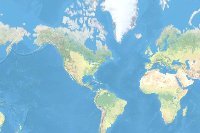

In [ ]:
item[3]

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving WATER_DATA_2019_CLEANED.csv to WATER_DATA_2019_CLEANED.csv


In [ ]:
dataPath = '/data/WATER_DATA_2019_CLEANED/WATER_DATA_2019_CLEANED_0.csv'
df = pd.read_csv(dataPath)
df

In [ ]:
df.isnull().sum()

In [ ]:
#df2 = df.dropna(subset=['WATER_TEMP'])
#df2.isnull().sum()
#df2
dfEX = df.dropna(subset=['WATER_TEMP'])
dfEX

In [ ]:
writer = pd.ExcelWriter(exportName, engine='xlsxwriter')
      df.to_excel(writer, sheet_name='Sheet1', index=False)
      writer.save()
      print(f'dataframe successfully exported as: {exportName}')
      return df